In [1]:
import pandas as pd
import numpy as np
import feather
import pickle
import geopandas as gpd
from polyfuzz import PolyFuzz
from polyfuzz.models import EditDistance, TFIDF, Embeddings
from flair.embeddings import TransformerWordEmbeddings

pd.options.display.max_columns = None


# Getting Tickets for 2020 and 2019 only

We are only concerned with tickets issued in 2020 and 2019 but data in fiscal year format with fiscal year running start July to End June - need to combine with 2018 and 2021 data for full year 2020 and 2019. 

In [ ]:
all_files=['Data/tickets/Parking_Violations_Issued_-_Fiscal_Year_2018.csv',
           'Data/tickets/Parking_Violations_Issued_-_Fiscal_Year_2019.csv',
           'Data/tickets/Parking_Violations_Issued_-_Fiscal_Year_2020.csv',
           'Data/tickets/Parking_Violations_Issued_-_Fiscal_Year_2021.csv'
          ]

# For all tickets issued in 2019

with open('Data/tickets/ticket2019.csv','w') as outfile:
    for i, filename in enumerate(all_files):
        with open(filename,'r') as infile:
            for rownum, line in enumerate(infile):
                if (i == 0) and (rownum==0):
                    outfile.write(line +'\n')
                elif(i != 0) and (rownum==0):     # only write header once
                    continue
                elif ('2019' in line.split(',')[4]):
                    outfile.write(line +'\n')

# For all tickets issued in 2020
                         
with open('Data/tickets/ticket2020.csv','w') as outfile:
    for i, filename in enumerate(all_files):
        with open(filename,'r') as infile:
            for rownum, line in enumerate(infile):
                if (i == 0) and (rownum==0):
                    outfile.write(line +'\n')
                elif (i != 0) and (rownum==0):     # only write header once
                    continue
                elif ('2020' in line.split(',')[4]):
                    outfile.write(line +'\n')

## Read the CSV files 

In [ ]:
ticket20=pd.read_csv('Data/tickets/ticket2020.csv')
ticket19=pd.read_csv('Data/tickets/ticket2019.csv')

## Change some column dtypes that have issues converting to feather from mix for float and strings

In [ ]:
ticket20['Issuer Squad']=ticket20['Issuer Squad'].astype(str)
ticket20['Violation Legal Code']=ticket20['Violation Legal Code'].astype(str)
ticket20['Unregistered Vehicle?']=ticket20['Unregistered Vehicle?'].astype(str)
ticket20['Meter Number']=ticket20['Meter Number'].astype(str)
ticket20['Violation Post Code']=ticket20['Violation Post Code'].astype(str)

ticket19['Issuer Squad']=ticket19['Issuer Squad'].astype(str)
ticket19['Violation Legal Code']=ticket19['Violation Legal Code'].astype(str)
ticket19['Unregistered Vehicle?']=ticket19['Unregistered Vehicle?'].astype(str)
ticket19['Meter Number']=ticket19['Meter Number'].astype(str)
ticket19['Violation Post Code']=ticket19['Violation Post Code'].astype(str)
ticket19['House Number']=ticket19['House Number'].astype(str)

## Save raw tickets data to Feather for fast loading

In [ ]:
ticket20.to_feather('ticket20.feather')
ticket19.to_feather('ticket19.feather')

## Load from Feather to reduce wait/processing time

In [2]:
ticket20=pd.read_feather('ticket20.feather')
ticket19=pd.read_feather('ticket19.feather')

# Geocode 1 - Speeding and Redlights

Create subset of data from tickets for violation code 7 or 36 AND street code 1 is 0.

These represent a significant portion of the data and hence we will need to geocode their location seperately using google APIs

In [3]:
speedred20=ticket20[(ticket20['Street Code1']==0) & ((ticket20['Violation Code']==7)|(ticket20['Violation Code']==36))]
speedred19=ticket19[(ticket19['Street Code1']==0) & ((ticket19['Violation Code']==7)|(ticket19['Violation Code']==36))]

speedred_combined=pd.concat([speedred20,speedred19])

speedred_combined.reset_index(drop=True,inplace=True)
speedred_combined.to_feather('speedred_combined.feather')


# Geocode 2 - Unmatchable to LION

To match on LION we require House Number and Street Code 1

We get a seperate dataframe of non-matchable violations to map using geocode

In [4]:
def clean_df(df):
    df['House Number Clean']=df['House Number'].str.split('-').str[0]
    df['House Number Clean']=df['House Number Clean'].str.split(' ').str[0]
    df['House Number Clean']=df['House Number Clean'].str.replace('[^0-9]','',regex=True)
    df['House Number Clean'].replace({np.nan:0},inplace=True)
    df['House Number Clean'].replace({'':0},inplace=True)
    df['House Number Clean']=df['House Number Clean'].astype(float)
    return df

In [5]:
ticket20_clean=clean_df(ticket20)
ticket19_clean=clean_df(ticket19)

In [6]:
exclude=[7,36]
nonmatch20=ticket20_clean[(ticket20_clean['House Number Clean']==0) &\
                          (~ticket20_clean['Violation Code'].isin(exclude)) &\
                          (~ticket20_clean['Street Name'].isnull()) ]
nonmatch19=ticket19_clean[(ticket19_clean['House Number Clean']==0) &\
                          (~ticket19_clean['Violation Code'].isin(exclude)) &\
                          (~ticket19_clean['Street Name'].isnull()) ]

In [7]:
nonmatch_combined=pd.concat([nonmatch20,nonmatch19])

nonmatch_combined.reset_index(drop=True,inplace=True)
nonmatch_combined.to_feather('nonmatch_combined.feather')

# Geocode 3 - Failed BERT

Finally to salvage as many datapoints as possible - we fuzzy string match using BERT match as much as possible - balance we will consider for Geocoding - first we get the data with missing street codes and street name is not null. We will need to map on segment so we have to have a house number as well (exclude violation 7 and 36 - speedred)

In [8]:
for_bert_20 = ticket20_clean[(ticket20_clean['House Number Clean']!=0) &\
                          (~ticket20_clean['Violation Code'].isin(exclude)) &\
                          (ticket20_clean['Street Code1']==0) &\
                          (~ticket20_clean['Street Name'].isnull()) ].copy()

for_bert_19 = ticket19_clean[(ticket19_clean['House Number Clean']!=0) &\
                          (~ticket19_clean['Violation Code'].isin(exclude)) &\
                          (ticket19_clean['Street Code1']==0) &\
                          (~ticket19_clean['Street Name'].isnull()) ].copy()

We will be running a BERT for each boro - More accurate so we have to clean up the Violation County in the ticket data

In [9]:
boro_dict = {'NY':'1',
             'MN':'1',
             'BX':'2',
             'K':'3',
             'K F':'3',
             'BK':'3',
             'KINGS':'3',
             'Q':'4',
             'P' : '0',
             'QN':'4',
             'QUEEN':'4',
             'QNS':'4',
             'R':'5',
             'RICH':'5',
             'ST':'5',
             'None':'0'
            }

for_bert_20['Boro Code'] = for_bert_20['Violation County'].map(boro_dict)
for_bert_19['Boro Code'] = for_bert_19['Violation County'].map(boro_dict)

for_bert_20['Boro Code'].replace({np.nan:0},inplace=True)
for_bert_19['Boro Code'].replace({np.nan:0},inplace=True)

Then write a quick function to cleans some common street naming conventions to improve BERT matching performance

In [10]:
def clean_street_bert(df):
    '''
    Function cleans the street names slightly for better matching in BERT
    '''
    
    # clean white space
    df['Street Clean'] = df['Street Name'].str.replace(' +',' ',regex=True)
    
    # standardize some common street name patterns
    df['Street Clean'] = df['Street Clean'].str.replace(r"(E) ([0-9]+) (ST)",'EAST \g<2> STREET',regex=True)
    df['Street Clean'] = df['Street Clean'].str.replace(r"(W) ([0-9]+) (ST)",'WEST \g<2> STREET',regex=True)

    df['Street Clean'] = df['Street Clean'].str.replace(r" ST$",' STREET',regex=True)

    df['Street Clean'] = df['Street Clean'].str.replace(r" AVE$",' AVENUE',regex=True)
    
    df['Street Clean'] = df['Street Clean'].str.replace(r" PL$",' PLACE',regex=True)

    df['Street Clean'] = df['Street Clean'].str.replace(r" BLVD$",' BOULEVARD',regex=True)

    # ADD MORE ABOVE HERE IF REQUIRED 
    
    return (df)

In [11]:
for_bert_20=clean_street_bert(for_bert_20)
for_bert_19=clean_street_bert(for_bert_19)
combinedbert=pd.concat([for_bert_20,for_bert_19])

In [12]:
combinedbert

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation,House Number Clean,Boro Code,Street Clean
32,1437336553,AL86861,NY,PAS,07/16/2020,20,SUBN,FORD,X,0,40404,40404,20200106,49.0,49,976,101319,0976,0000,1227P,None,BX,F,1400,PELHAM PRKW SOUTH,None,0,408,D5,nan,BBBBBBB,ALL,ALL,GRAY,0.0,2013,-,0,nan,None,NaN,NaN,NaN,1400.0,2,PELHAM PRKW SOUTH
51,1334903323,GEL6779,NY,PAS,09/06/2020,46,SDN,BUICK,X,0,40404,40404,20190523,107.0,107,976,100246,0976,0000,0930A,None,Q,F,82-68,164TH JAMAICA AVE,None,0,408,D5,nan,BBBBBBB,ALL,ALL,BLACK,0.0,2017,-,0,nan,None,NaN,NaN,NaN,82.0,4,164TH JAMAICA AVENUE
58,1446558095,FCW6319,NY,PAS,10/17/2020,67,SDN,ME/BE,P,0,40404,40404,20200726,103.0,103,103,964303,0103,0000,0147P,None,Q,F,173-06,WARWICK,None,0,408,F2,nan,BBBBBBB,ALL,ALL,G,0.0,2014,-,0,nan,None,NaN,NaN,NaN,173.0,4,WARWICK
76,1450973747,HJW3333,NY,PAS,10/20/2020,21,OLNE,HONDA,S,0,40404,40404,20200920,45.0,45,0,539565,BX10,0000,0940A,None,BX,O,1530,HUTCHINSON RV PKWY,None,0,408,D1,nan,BBBBBYB,0930A,1100A,WHITE,0.0,2004,-,0,nan,None,NaN,NaN,NaN,1530.0,2,HUTCHINSON RV PKWY
94,1447748890,GNE5062,NY,PAS,01/11/2020,98,SDN,ACURA,P,0,40404,40404,20200211,109.0,109,109,955195,0109,0000,0957A,None,Q,F,146-20,NEGANDO,None,0,408,F2,nan,BBBBBBB,ALL,ALL,None,0.0,0,-,0,nan,None,NaN,NaN,NaN,146.0,4,NEGANDO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12774691,1458075382,EWL4304,NY,PAS,10/16/2019,98,SUBN,TOYOT,P,0,40404,40404,20200128,76.0,76,76,935377,0076,0.0,0700P,None,K,O,400,HERNY ST,None,0,408,F2,nan,BBBBBBB,ALL,ALL,GRY,0.0,2010,-,0,nan,None,NaN,NaN,NaN,400.0,3,HERNY STREET
12774693,1464743083,89989MK,NY,COM,12/12/2019,47,DELV,FRUEH,P,0,40404,40404,20200930,NaN,0,401,958206,0401,0.0,1100A,None,NY,F,1624,KINGS HWY,None,0,408,C3,nan,BBBBBBB,ALL,ALL,WH,0.0,2017,-,0,nan,None,NaN,NaN,NaN,1624.0,1,KINGS HWY
12774694,1464743095,89989MK,NY,COM,12/12/2019,45,DELV,FRUEH,P,0,40404,40404,20200930,NaN,0,401,958206,0401,0.0,1100A,None,NY,None,1624,KINGS HIGHWAY,None,0,408,L2,nan,BBBBBBB,ALL,ALL,WH,0.0,2017,-,0,nan,None,NaN,NaN,NaN,1624.0,1,KINGS HIGHWAY
12774695,1464743149,ZHC3025,PA,PAS,12/12/2019,45,DELV,ISUZU,P,0,40404,40404,0,NaN,0,401,958206,0401,0.0,1055A,None,K,F,1416,KINGS HIGHWAY,None,0,408,E1,nan,BBBBBBB,ALL,ALL,WH,0.0,2014,-,0,nan,None,NaN,NaN,NaN,1416.0,3,KINGS HIGHWAY


In [ ]:
# load the LION data to get match list

lion = gpd.read_file("Data/LION/LION.shp")

In [ ]:
# get BERT match_to and match_from lists for each boro

match_list_b1 = lion[lion['LBoro']==1]['Street'].unique().tolist()
match_list_b2 = lion[lion['LBoro']==2]['Street'].unique().tolist()
match_list_b3 = lion[lion['LBoro']==3]['Street'].unique().tolist()
match_list_b4 = lion[lion['LBoro']==4]['Street'].unique().tolist()
match_list_b5 = lion[lion['LBoro']==5]['Street'].unique().tolist()

from_list_b1=combinedbert[combinedbert['Boro Code']=='1']['Street Clean'].dropna().unique().tolist()
from_list_b2=combinedbert[combinedbert['Boro Code']=='2']['Street Clean'].dropna().unique().tolist()
from_list_b3=combinedbert[combinedbert['Boro Code']=='3']['Street Clean'].dropna().unique().tolist()
from_list_b4=combinedbert[combinedbert['Boro Code']=='4']['Street Clean'].dropna().unique().tolist()
from_list_b5=combinedbert[combinedbert['Boro Code']=='5']['Street Clean'].dropna().unique().tolist()

In [ ]:
# 'Pipeline' to run Bert/tfidf/edit for each boro

embeddings = TransformerWordEmbeddings('bert-base-multilingual-cased')
bert = Embeddings(embeddings, min_similarity=0,top_n=3,model_id="BERT")
tfidf = TFIDF(min_similarity=0,model_id='TF-IDF')
edit = EditDistance(model_id='EDIT_DIST')
string_models = [bert, tfidf, edit]


model_b1 = PolyFuzz(string_models)
model_b1.match(from_list_b1, match_list_b1)

model_b2 = PolyFuzz(string_models)
model_b2.match(from_list_b2, match_list_b2)

model_b3 = PolyFuzz(string_models)
model_b3.match(from_list_b3, match_list_b3)

model_b4 = PolyFuzz(string_models)
model_b4.match(from_list_b4, match_list_b4)

model_b5 = PolyFuzz(string_models)
model_b5.match(from_list_b5, match_list_b5)

In [ ]:
pickle.dump(model_b1, open('BERT Models/model_b1.sav','wb'))
pickle.dump(model_b2, open('BERT Models/model_b2.sav','wb'))
pickle.dump(model_b3, open('BERT Models/model_b3.sav','wb'))
pickle.dump(model_b4, open('BERT Models/model_b4.sav','wb'))
pickle.dump(model_b5, open('BERT Models/model_b5.sav','wb'))

In [13]:
# Load saved models to save time

model_b1 = pickle.load(open('BERT Models/model_b1.sav','rb'))
model_b2 = pickle.load(open('BERT Models/model_b2.sav','rb'))
model_b3 = pickle.load(open('BERT Models/model_b3.sav','rb'))
model_b4 = pickle.load(open('BERT Models/model_b4.sav','rb'))
model_b5 = pickle.load(open('BERT Models/model_b5.sav','rb'))

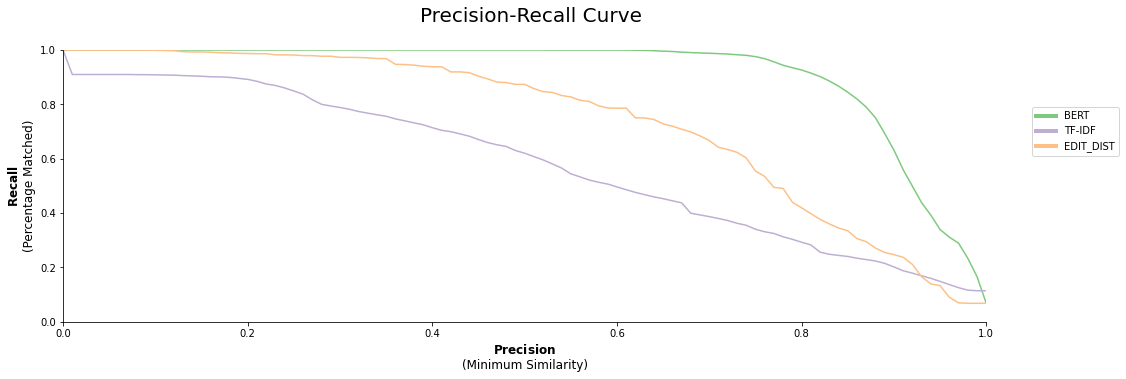

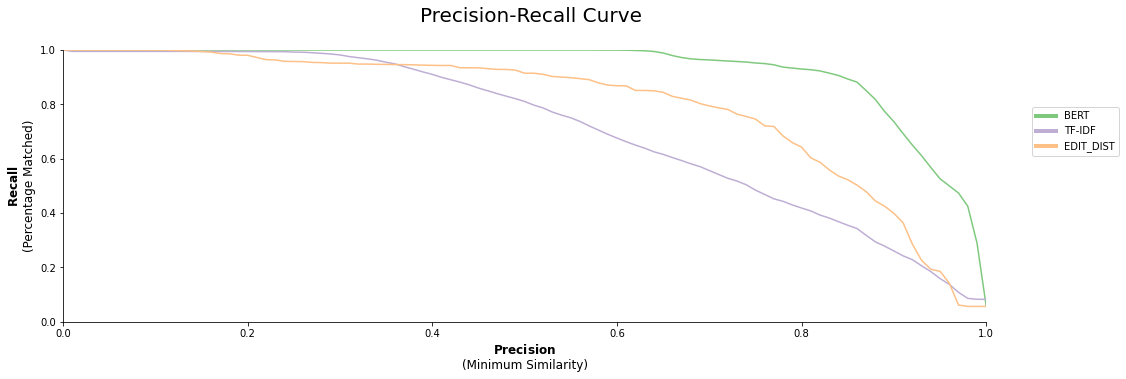

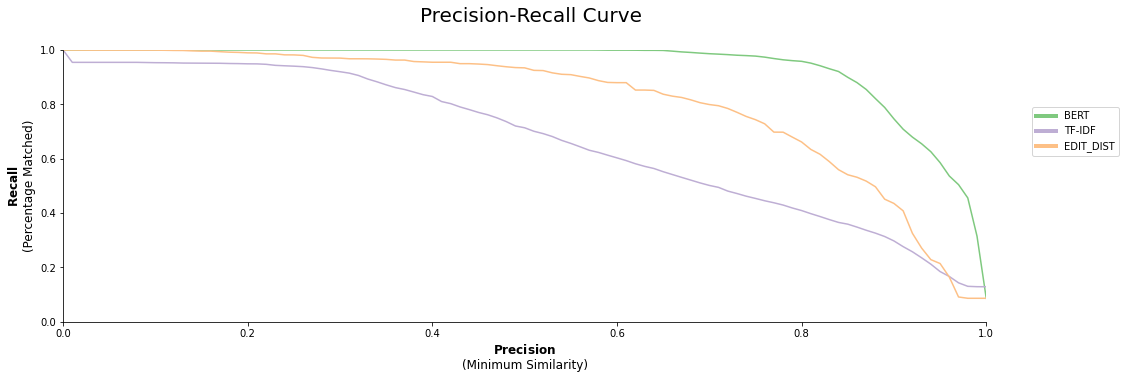

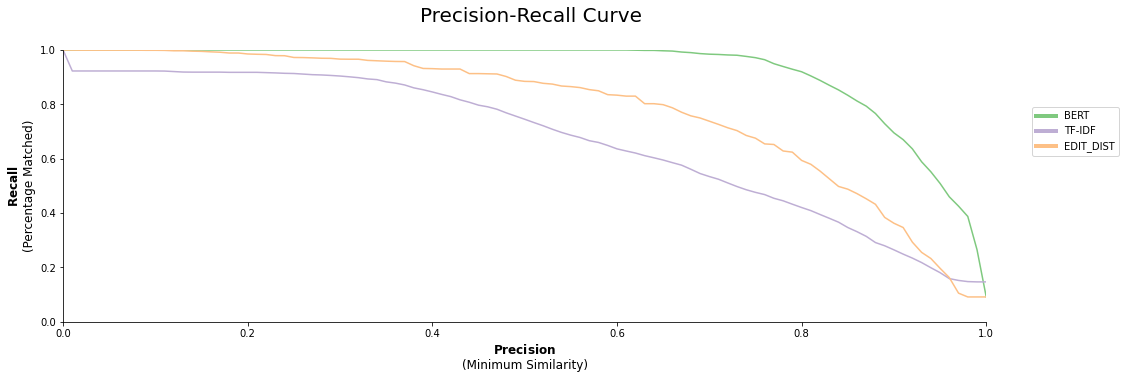

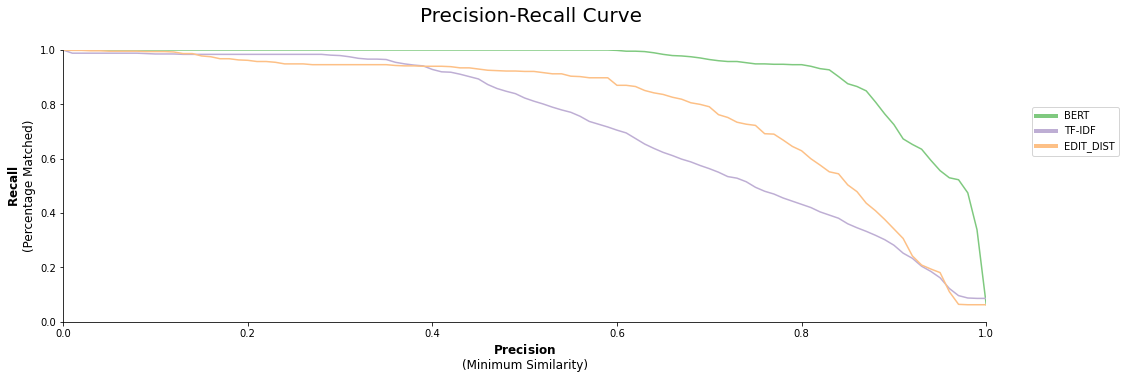

In [14]:
model_b1.visualize_precision_recall()
model_b2.visualize_precision_recall()
model_b3.visualize_precision_recall()
model_b4.visualize_precision_recall()
model_b5.visualize_precision_recall()

In [15]:
matchb1 = model_b1.get_matches('BERT')
matchb2 = model_b2.get_matches('BERT')
matchb3 = model_b3.get_matches('BERT')
matchb4 = model_b4.get_matches('BERT')
matchb5 = model_b5.get_matches('BERT')

In [16]:
threshold = 0.93

b1_dict = matchb1[matchb1['Similarity']>=threshold].set_index('From').to_dict()['To']
b2_dict = matchb2[matchb2['Similarity']>=threshold].set_index('From').to_dict()['To']
b3_dict = matchb3[matchb3['Similarity']>=threshold].set_index('From').to_dict()['To']
b4_dict = matchb4[matchb4['Similarity']>=threshold].set_index('From').to_dict()['To']
b5_dict = matchb5[matchb5['Similarity']>=threshold].set_index('From').to_dict()['To']

In [17]:
match_dict={**b1_dict,**b2_dict,**b3_dict,**b4_dict,**b5_dict}

In [18]:
combinedbert['Street Name BERT']=combinedbert['Street Name'].map(match_dict)

In [19]:
failedbert=combinedbert[combinedbert['Street Name BERT'].isnull()].copy()
failedbert['Boro Code']=failedbert['Boro Code'].astype(str)

In [20]:
failedbert.reset_index(drop=True, inplace=True)
failedbert.to_feather('failedbert.feather')

In [21]:
speedred_combined['Summons Number'].tolist()

[5109306230,
 5109308240,
 4675196068,
 4675150573,
 4675150536,
 4675247659,
 4675382174,
 5109308640,
 5109308639,
 5109308627,
 5109308585,
 5109308536,
 5109308494,
 5109308469,
 5109308457,
 5109308421,
 5109308408,
 5109308391,
 5109308378,
 5109308354,
 5109308342,
 5109308329,
 5109308317,
 5109308299,
 5109308275,
 5109308238,
 5109308196,
 5109308184,
 5109308160,
 5109308159,
 5109308135,
 5109308081,
 5109308056,
 5109308044,
 5109308007,
 5109307969,
 5109307933,
 5109307854,
 5109307842,
 5109307805,
 5109307787,
 5109307775,
 5109307751,
 5109307738,
 5109307702,
 5109307684,
 5109307647,
 5109307635,
 5109307623,
 5109307570,
 5109307519,
 5109307416,
 5109307404,
 5109307398,
 5109307386,
 5109307350,
 5109307349,
 5109307337,
 5109307313,
 5109307301,
 5109307222,
 5109307210,
 5109307179,
 5109307167,
 5109307155,
 5109307120,
 5109307088,
 5109307076,
 5109307064,
 5109307052,
 5109307040,
 5109307015,
 5109306990,
 5109306930,
 5109306916,
 5109306898,
 5109306886,

In [22]:
exclusion_summons=[]

exclusion_summons.append(speedred_combined['Summons Number'].tolist())
exclusion_summons.append(nonmatch_combined['Summons Number'].tolist())
exclusion_summons.append(failedbert['Summons Number'].tolist())
pickle.dump(exclusion_summons, open('Data/exclusion_list.sav','wb'))

In [28]:
ticket20_reduced=ticket20[~ticket20['Summons Number'].isin(exclusion_summons[0])]

In [32]:
ticket19_reduced=ticket19[~ticket19['Summons Number'].isin(exclusion_summons[0])]

In [36]:
ticket20_reduced.reset_index(drop=True, inplace=True)
ticket20_reduced.to_feather('ticket_reduced20.feather')

In [37]:
ticket19_reduced.reset_index(drop=True, inplace=True)
ticket19_reduced.to_feather('ticket_reduced19.feather')

In [ ]:
ticket_combined=pd.concat([ticket20_reduced,ticket19_reduced])
ticket_combined.reset_index(drop=True, inplace=True)

In [ ]:
ticket_combined.to_feather('ticket_combined.feather')